Dr. Tobias Gensch, 2022

Gensch, T.; Smith, S.; Colacot, T.; Timsina, Y.; Xu, G.; Glasspoole, B.; Sigman, M.

Design and Application of a Screening Set for Monophosphine Ligands in Cross-Coupling

ACS Catalysis, 2022

https://doi.org/10.1021/acscatal.2c01970


# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from sklearn.cluster import KMeans

from rdkit import Chem,Geometry
from rdkit.Chem import rdmolfiles, AllChem, rdMolAlign,rdmolops, Descriptors, Draw, PandasTools

from collections import Counter

In [2]:
# only necessary for the interactive dashboards 

from dash import Dash, dcc, html, Input, Output, State, no_update
import plotly.graph_objects as go
from jupyter_dash import JupyterDash

In [13]:
colors32 = ['#000000', '#222034', '#45283c', '#663931', '#8f563b', '#df7126', '#d9a066', '#eec39a', '#fbf236', '#99e550', '#6abe30', '#37946e', '#4b692f', '#524b24', '#323c39', '#3f3f74', '#306082', '#5b6ee1', '#639bff', '#5fcde4', '#cbdbfc', '#dddddd', '#9badb7', '#847e87', '#696a6a', '#595652', '#76428a', '#ac3232', '#d95763', '#d77bba', '#8f974a', '#8a6f30']

def mol_to_img_df(row):
    mol = Chem.MolFromSmiles(row["smiles"])
    return(Draw.MolToImage(mol))

def dist_to_center(line):
    delta = line[use_cols] - kmeans.cluster_centers_[line["cluster"]]
    dist = np.linalg.norm(delta)
    return(dist)

# Read Data

The file "descriptors.xlsx" with the phosphorus ligand descriptors can be found in the supporting information of the original kraken publication:
https://pubs.acs.org/doi/suppl/10.1021/jacs.1c09718/suppl_file/ja1c09718_si_002.zip

Please also cite the paper when using this data:

Gensch, T.; dos Passos Gomes, G.; Friederich, P.; Peters, E.; Gaudin, T.; Pollice, R.; Jorner, K.; Nigam, A.; Lindner-D’Addario, M.; Sigman, M. S.; Aspuru-Guzik, A. 
A Comprehensive Discovery Platform for Organophosphorus Ligands for Catalysis. 
J. Am. Chem. Soc. 2022, 144 (3), 1205–1217. 
https://doi.org/10.1021/jacs.1c09718

In [4]:
features = pd.read_excel("descriptors.xlsx", sheet_name="reduced_features_DFT", 
                         index_col = 0)

print("Features")
print(features.shape)
display(features.head())

Features
(1544, 7)


,smiles,PC1,PC2,PC3,PC4,umap1,umap2
ID,,,,,,,
1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2...,11.256186,-0.657241,7.758946,-3.247701,8.318198,4.733678
2,CN(C)c1cccc(N(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1,8.845686,0.595407,6.739153,-2.817894,8.365421,4.867214
3,COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1,7.116978,0.838970,5.035702,-2.497649,8.296419,4.997310
4,CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CC...,10.818188,-1.557446,7.481010,-3.170921,8.531631,4.877754
5,c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1,5.141353,1.328914,6.591504,-2.483875,8.091322,5.610940


The file "phoss_filters.csv" is found in the supporting information of the original PHOSS publication (https://doi.org/10.1021/acscatal.2c01970).

It contains various categories that can be used as filters for the screening set design of phosphorus ligands.

pat and pat_enc contain the 9 categories based on the elements at phosphorus that were used to generate the images in Figure 4 A and B of the original kraken publication, where pat_enc is a numeric encoding of pat.

This is followed by columns with binary information on various substructures, such as substitution with certain elements, Buchwald-type ligands ("buch") or presence of phosphacycles ("ring"). 

"com" indicates commercial availability based on SciFinder searches in 2018 and 2020, as described in the PHOSS publication and used to filter by commercial availability there.

"PHOSS" indicates the 32 ligands in the phosphine optimization screening set.

The last four columns "yield_casestudy_A","yield_casestudy_B","yield_casestudy_C","yield_casestudy_D" contain the assay yields in the respective case studies included in the PHOSS publication.

In [5]:
filters = pd.read_csv("phoss_filters.csv", index_col = 0)

print("Filters")
print(filters.shape)
display(filters.head())

Filters
(1544, 37)


,smiles,pat,pat_enc,ph,ph3,pb,pb3,pc,pc3,pn,...,pon,par3,buch,ring,com,PHOSS,yield_casestudy_A,yield_casestudy_B,yield_casestudy_C,yield_casestudy_D
1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2...,pc3,0,0,0,0,0,1,1,0,...,0,0,1,0,1,0,66.0,25.5,NaN,NaN
2,CN(C)c1cccc(N(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1,pc3,0,0,0,0,0,1,1,0,...,0,0,1,0,1,0,NaN,NaN,NaN,NaN
3,COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1,pc3,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,53.5,92.0,87.222270,0.005
4,CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CC...,pc3,0,0,0,0,0,1,1,0,...,0,0,1,0,1,0,51.5,3.0,74.482051,NaN
5,c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1,pc3,0,0,0,0,0,1,1,0,...,0,0,1,0,1,0,51.0,21.0,NaN,NaN


# Filtering

In [15]:
use_rows = features.index # use this if no filtering is applied

# apply optional filtering here. Un/Comment as required

# for example: filter by commercial availability
criterion1 = set(filters.loc[filters["com"] == 1].index)

# for example: only phosphines and phosphine amines / mixed C,N substitution
# pat_filter = ["pc3","pcn","pn3"]
# criterion2 = set(filters[filters["pat"].isin(pat_filter)].index)

# or: just phosphines
criterion2 = set(filters.loc[filters["pat"] == "pc3"].index)

# when using more than 1 criterion, use set operations to combine filter results
# use_rows = sorted(criterion1)
use_rows = sorted(criterion1 & criterion2)
                    
print(f"Keeping {len(use_rows)} compounds.")

Keeping 319 compounds.


# Clustering

In [7]:
# How many clusters to generate:
nclusters = 32

# Which feature space to use for the clustering: PCA/umap
use_space = "PCA" 


In [16]:
# train the clustering. No user changes needed

find_cols = {"PCA": ["PC1","PC2","PC3","PC4"],
             "umap": ["umap1","umap2"],}

use_cols = find_cols[use_space]
X_kmeans = features.loc[use_rows,use_cols]

kmeans = KMeans(n_clusters=nclusters, random_state=1).fit(X_kmeans)
data_df = features.loc[use_rows].copy()

data_df["closest_to_center"] = 0
data_df["cluster"] = kmeans.labels_
data_df["distance_to_center"] = data_df.apply(dist_to_center, axis = 1)
clustermins = []
for clusternumber in range(nclusters):
    min_to_center_idx = data_df[data_df["cluster"] == clusternumber]["distance_to_center"].idxmin()
    clustermins.append(min_to_center_idx)
    data_df.loc[min_to_center_idx,"closest_to_center"] = 1

clustercounts = Counter(data_df["cluster"])
print("cluster: N(samples)")
for i in sorted(clustercounts.keys()):
    print(f"{i}: {clustercounts[i]}")

cluster: N(samples)
0: 6
1: 13
2: 30
3: 3
4: 13
5: 15
6: 11
7: 9
8: 16
9: 10
10: 7
11: 13
12: 15
13: 19
14: 11
15: 12
16: 4
17: 7
18: 3
19: 10
20: 22
21: 1
22: 1
23: 11
24: 9
25: 5
26: 10
27: 1
28: 6
29: 15
30: 5
31: 6


# Visualization, Inspection

## Ligands closest to the cluster centers

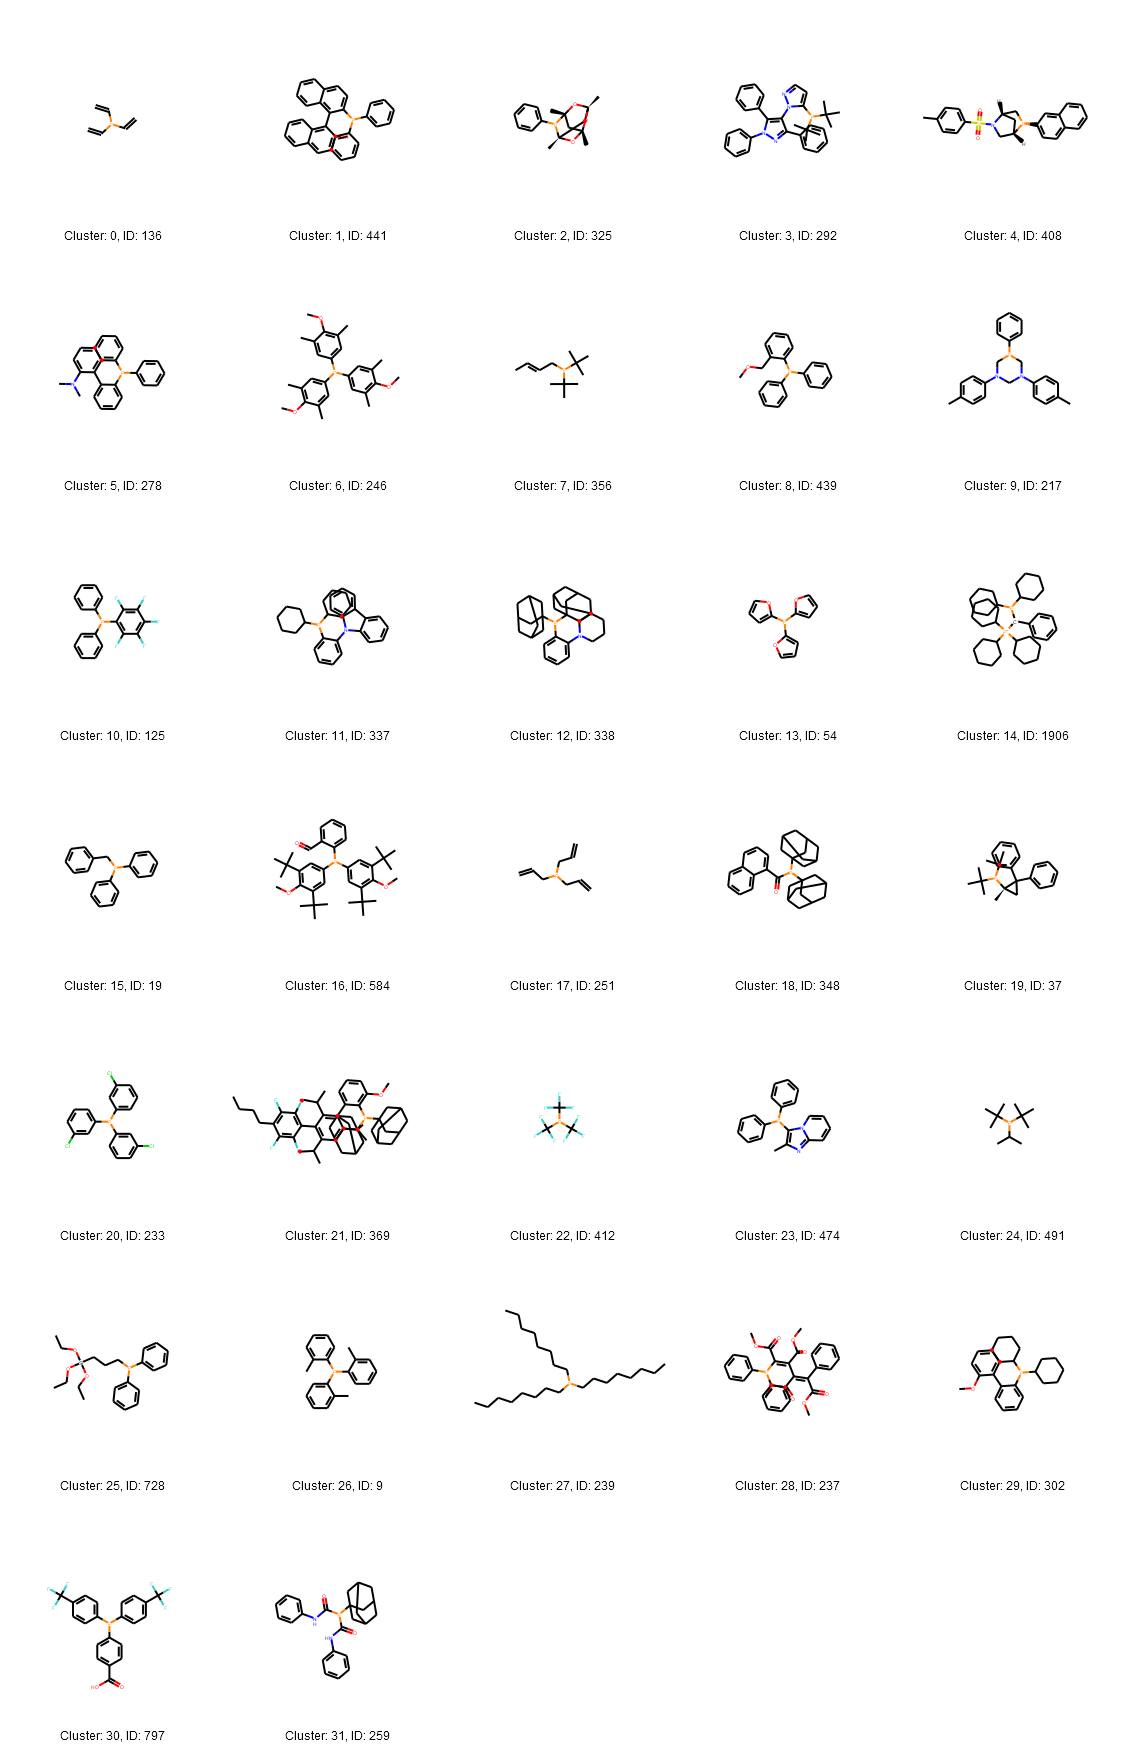

In [9]:
molobs = [Chem.MolFromSmiles(i) for i in data_df.loc[clustermins]["smiles"]]
legends = [f"Cluster: {k}, ID: {v}" for k,v in enumerate(clustermins)]
img_src = Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=4,
                                  legends = legends)
Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=5,
                                  legends = legends)

## Inspect clusters individually

### Interactive

In [20]:
# no user changes needed

app = JupyterDash(__name__)

app.layout = html.Div([  
    html.Div("Select cluster:"),
    html.Div(
        dcc.RadioItems(
            id = 'clusters_select',
            options = [{'value': x, 'label': x}
            for x in range(nclusters)],
            value = 0,
            labelStyle={"display": "inline-block"},
    ),
        style = {"width": "60%", "display":"inline-block"}
    ),
    
    html.P(),
    
    html.Div(["Show up to N molecules nearest to the cluster center: ",
        dcc.Input(
            id = "show_n_mols", type = "number", value = 4, min = 1, step = 1,
            style={"width":"5%"}
        )
    ]),
    
    html.Img(id="molecules_img"),
])

@app.callback(
    Output("molecules_img", "src"),
    [Input("show_n_mols","value"),Input("clusters_select","value")]
    )

def generate_molimg(show_n_mols,clusters_select):
    show_n_mols = int(show_n_mols)
    clustermin_idx = clustermins[clusters_select]
    
    sorted_mols = data_df.loc[data_df["cluster"] == clusters_select].sort_values(by="distance_to_center")
    showno = min(show_n_mols,len(sorted_mols))
    show_idxs = sorted_mols.iloc[:showno].index
    molobs = [Chem.MolFromSmiles(i) for i in sorted_mols.loc[show_idxs,"smiles"]]
    legends = [f"ID: {i}, Dist: {data_df.loc[i,'distance_to_center']:.2f}" for i in show_idxs]
    img_src = Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=4,
                                  legends = legends)
    
    return(img_src)

app.run_server(mode='inline', port = 5009)

### Static

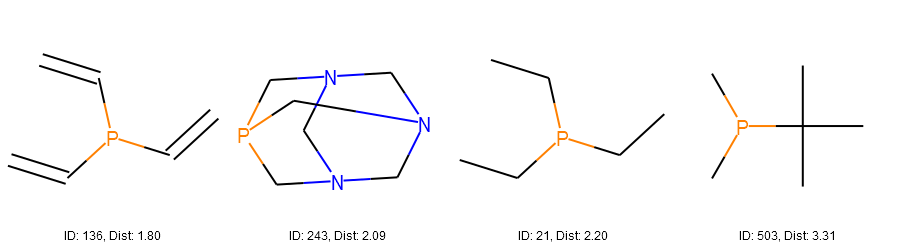

In [17]:
show_n_mols = 4    # Show up to N molecules nearest to the cluster center
cluster_select = 0 # which cluster to inspect

#####

def generate_molimg(show_n_mols,clusters_select):
    show_n_mols = int(show_n_mols)
    clustermin_idx = clustermins[clusters_select]
    
    sorted_mols = data_df.loc[data_df["cluster"] == clusters_select].sort_values(by="distance_to_center")
    showno = min(show_n_mols,len(sorted_mols))
    show_idxs = sorted_mols.iloc[:showno].index
    molobs = [Chem.MolFromSmiles(i) for i in sorted_mols.loc[show_idxs,"smiles"]]
    legends = [f"ID: {i}, Dist: {data_df.loc[i,'distance_to_center']:.2f}" for i in show_idxs]
    img_src = Draw.MolsToGridImage(molobs, subImgSize=(225,250), molsPerRow=4,
                                  legends = legends)
    
    return(img_src)

generate_molimg(show_n_mols,cluster_select)

## Chemical Space plots

### Interactive

In [19]:
# no user changes needed

color_feature = "cluster"
color_list = colors32

if len(color_list) > nclusters:
    color_list = color_list[:nclusters]

interval = 1/(len(color_list)-1)
colorcode = []
for n,i in enumerate(color_list):    # there might be an easier way but this makes a pretty-ish discrete colorbar
    if n == 0:
        start = 0.0
        end = interval/2        
    elif n == len(color_list)-1:
        start = end
        end = 1.0        
    else:
        start = end
        end = start + interval

    colorcode.append([start,i])
    colorcode.append([end, i])        
    
dimensions = [dim for dimtype in find_cols.values() for dim in dimtype if dim in data_df.columns]
    
app = JupyterDash(__name__)

app.layout = html.Div([  
    
    html.Div([
         html.Div("X:"),
    ],
        style = {"width": "19%", "display":"inline-block"}
    ),
    
    html.Div([
         html.Div("Y:"),
    ], 
        style = {"width": "19%", "display":"inline-block"}
    ),
    
    html.Div(),
    
    html.Div([
         dcc.Dropdown(
            options = [{'value': x, 'label': x} for x in dimensions], 
            value = dimensions[0],
            id="x_source"),
    ],
        style = {"width": "19%", "display":"inline-block"}
    ),
    
    html.Div([
         dcc.Dropdown(
            options = [{'value': x, 'label': x} for x in dimensions], 
            value = dimensions[1],
            id="y_source"),
    ], 
        style = {"width": "19%", "display":"inline-block"}
    ),
    
    html.Div([
         html.Div(""),
    ], 
        style = {"width": "2%", "display":"inline-block"}
    ),
    
    html.Div([
        dcc.Checklist(
            id="centersonly",
            options=[{"label": "Show only compounds closest to cluster center", "value": 1}],
            value=[],
            labelStyle={"display": "inline-block"},
        )],
        style = {"width": "19%", "display":"inline-block"}
    ),
    
    html.P(),
    
    html.Div([
        html.Div("Select Clusters"),
        dcc.Checklist(
            id="all-or-none",
            options=[{"label": "All", "value": "All"}],
            value=[],
            labelStyle={"display": "inline-block"},
        )],style = {"width": "15%", "display":"inline-block"}
    ),
    
    html.Div(
        dcc.Checklist(
            id = 'clusters_select',
            options = [{'value': x, 'label': x}
            for x in range(nclusters)],
    #         value = 0,
            labelStyle={"display": "inline-block"},
    #         inline=True,
    ),style = {"width": "60%", "display":"inline-block"}
    ),
    
    dcc.Graph(id="graph-basic-2", clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
    
])

@app.callback(
    Output("clusters_select", "value"),
    [Input("all-or-none", "value")],
    [State("clusters_select", "options")],
)

def select_all_none(all_selected, options):
    all_or_none = []
    all_or_none = [option["value"] for option in options if all_selected]
    return all_or_none

@app.callback(
    Output("graph-basic-2", "figure"),
    [Input("x_source", "value"),Input("y_source", "value"), Input("clusters_select","value"),Input("centersonly","value")]
    )

def generate_chart(x_source,y_source,clusters_select,centersonly):
    
    x_feature = x_source
    y_feature = y_source
    
    if clusters_select == None or clusters_select == []:
        clusters_select = [i for i in range(nclusters)]    
    else:
        clusters_select = sorted(clusters_select)

    if centersonly != []:
        cont_select = data_df[data_df['cluster'].isin(clusters_select) & data_df["closest_to_center"] == 1].sort_values(by="closest_to_center",ascending=True).index
    else:
        cont_select = data_df[data_df['cluster'].isin(clusters_select)].sort_values(by="closest_to_center",ascending=True).index
        
    markersymbols = {0:"square", 1:"diamond"}
        
#     my_layout = go.Layout({"showlegend": False,})
    fig = go.Figure(data=[
        go.Scatter(
            x=data_df.loc[cont_select,x_feature], 
            y=data_df.loc[cont_select,y_feature], 
            mode="markers",
            marker=dict(size=5 + 2*data_df.loc[cont_select,"closest_to_center"],
                      symbol = [markersymbols[i] for i in data_df.loc[cont_select,"closest_to_center"]],
                      color = data_df.loc[cont_select,color_feature],
                      cmin = data_df[color_feature].min(),
                      cmax = data_df[color_feature].max(),
                      colorbar=dict(
                             title = "Cluster",
                             tick0=0,
                             dtick=1,
                                    ),
                      opacity = 0.75 + 0.25*data_df.loc[cont_select,"closest_to_center"],
                      colorscale = colorcode,
                      line_width=data_df.loc[cont_select,"closest_to_center"]*2,
                      line_color = "black",
                     ),
        ),
    ],)
    
    fig.update_traces(hoverinfo="none", hovertemplate=None)

    fig.update_layout(
        xaxis=dict(title = "{}".format(x_feature)),
        yaxis=dict(title = "{}".format(y_feature)),
        plot_bgcolor='rgba(255,255,255,0.1)',
        autosize=True,
        width=525,
        height=525,
        showlegend=False,
        margin=go.layout.Margin(
            l=0, #left margin
            r=0, #right margin
            b=0, #bottom margin
            t=0  #top margin
            )
    )   
    
    return(fig)

@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    [Input("graph-basic-2", "hoverData"),Input("clusters_select","value"),Input("centersonly","value")],
)

def display_hover(hoverData,clusters_select,centersonly):
    if hoverData is None:
        return False, no_update, no_update

    if clusters_select == None or clusters_select == []:
        clusters_select = [i for i in range(nclusters)]    
    else:
        clusters_select = sorted(clusters_select)

    if centersonly != []:
        cont_select = data_df[data_df['cluster'].isin(clusters_select) & data_df["closest_to_center"] == 1].sort_values(by="closest_to_center",ascending=True).index
    else:
        cont_select = data_df[data_df['cluster'].isin(clusters_select)].sort_values(by="closest_to_center",ascending=True).index
    
    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]

    df_row = data_df.loc[cont_select].iloc[num]
    img_src = mol_to_img_df(df_row)  
        
    name = df_row.name
    cluster = df_row.cluster

    children = [
        html.Div([
            html.P(f"{name}, {cluster}", style={"color": "black","font-family":"Arial", "font-weight":"bold", "text-align":"center"}),
            html.Img(src=img_src, style={"width": "100%"}),
        ], style={'width': '200px', 'white-space': 'normal'})
    ]

    return True, bbox, children

app.run_server(mode='inline', port = 5002)

### Static

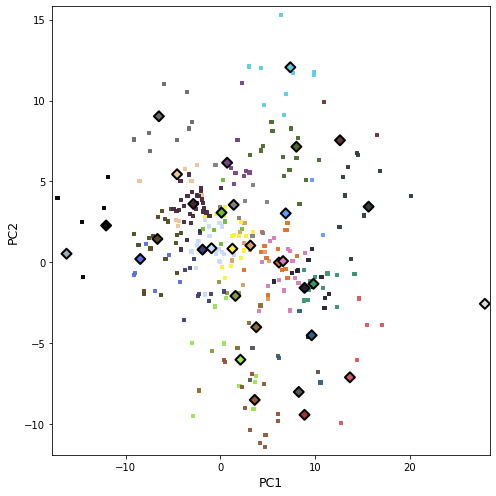

In [21]:
# no user changes needed

f_ind_1,f_ind_2 = use_cols[:2]

x_min, x_max = X_kmeans[f_ind_1].min() - .5, X_kmeans[f_ind_1].max() + .5
y_min, y_max = X_kmeans[f_ind_2].min() - .5, X_kmeans[f_ind_2].max() + .5

plt.figure(figsize=(7,7))
extent = [x_min,x_max,y_min,y_max]

mapping_cl = kmeans.labels_

cMap_cl = ListedColormap(colors32) 

plt.scatter(X_kmeans[f_ind_1], X_kmeans[f_ind_2],c=mapping_cl,cmap=cMap_cl,alpha=0.95,marker="s",s=10) 

plt.scatter(X_kmeans.loc[clustermins,f_ind_1], X_kmeans.loc[clustermins,f_ind_2],
        c=range(nclusters), cmap=cMap_cl,
        alpha=1, marker="D", s=50, edgecolor="black", linewidth=2)

plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.xlabel(f_ind_1,fontsize=12.5)
plt.ylabel(f_ind_2,fontsize=12.5)
plt.locator_params(axis='y', nbins=8)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.tight_layout()
plt.show()  
